## Decision making in low-rank recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# plt.style.use('dark_background')

### Perceptual decision makingg

__1. Create a function for generating the data.__

In [2]:
# Defining constants given in the exercise description.
mu = 0
std = 0.03
stim_strengths = 3.2 / 100 * np.array([1, 2, 4, 8, 16])

In [3]:
def get_input(u_bar, t_step, mu, std):
    u = np.zeros(t_step)
    for t in range(t_step):
        if 5 <= t <= 45:
            u[t] = u_bar + np.random.normal(mu, std)
        else:
            u[t] = np.random.normal(mu, std)
    
    return u

def generate_data(stim_strengths, t_step, mu, std):
    U = np.zeros((len(stim_strengths), t_step))
    y = np.zeros(len(stim_strengths))
    for trial, stim_strength in enumerate(range(len(stim_strengths))):
        u_bar = np.random.uniform(-stim_strengths[trial], stim_strengths[trial])
        U[trial] = get_input(u_bar, t_step, mu, std)
        y[trial] = np.sign(u_bar)
        
    return U, y

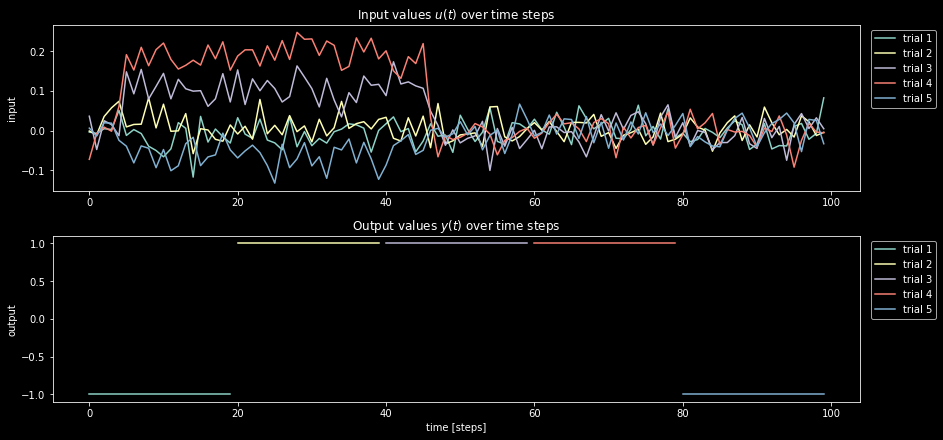

In [4]:
t_steps = 100
U, y = generate_data(stim_strengths, t_steps, mu, std)

fig, axs = plt.subplots(2, 1, figsize = (13, 6), constrained_layout = True)
for trial in range(U.shape[0]):
    axs[0].set_title(r'Input values $u(t)$ over time steps')
    axs[0].plot(np.arange(0, t_steps, 1), U[trial], label = f'trial {trial+1}')
    axs[0].set_ylabel('input')
    
    axs[1].set_title(r'Output values $y(t)$ over time steps')
    axs[1].plot(np.arange(trial * t_steps/U.shape[0], (trial+1) * t_steps/U.shape[0], 1), 
                np.full(int(t_steps/U.shape[0]), y[trial]), label = f'trial {trial+1}')
    axs[1].set_ylabel('output')
    axs[1].set_xlabel('time [steps]')

for i in range(2):
    axs[i].legend(loc = 'upper right', bbox_to_anchor = (1.1, 1))
plt.show()

__2. Implement the recurrent neural network in your favorite deep learning library.__

In [5]:
# Define the input-to-hidden, hidden-to-hidden and hidden-to-output matrices.
I = lambda N: np.random.normal(0, 1, N)
J = lambda N: 1 / N * (np.random.normal(0, 1, N).reshape(N, 1)@np.random.normal(0, 1, N).reshape(N, 1).T)
w = lambda N: np.random.normal(0, 1, N)

# Define the functions.
phi = lambda x: np.tanh(x)
dynamics = lambda u, x, N, t, tau=100: (-x + J(N)@phi(x) + I(N)*u[t]) / tau
output = lambda x, N: 1 / N * w(N)@phi(x)

In [6]:
def forward_euler(u, x, N, dt=20, tau=100):
    x = x + dt * dynamics(u, x, N, tau)
    return x

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, I, J, w, x):
        super(RNN, self).__init__()
        
        # Defining the number of layers and the nodes in each layer.
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layers.
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, bias=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Initialization of weights and biases.
        self.rnn.weight_ih_I = torch.from_numpy(I.T)
        self.rnn.weight_hh_I = torch.from_numpy(J)
        self.fc.weight.data = torch.from_numpy(w.reshape(output_size, hidden_size)).float()
        
        self.bias_ih_I = torch.from_numpy(-x)
        self.bias_hh_I = torch.from_numpy(np.zeros(hidden_size))
        self.fc.bias.data = torch.from_numpy(np.zeros(output_size)).float()
        
    def forward(self, u, X):
        # Initializing input and hidden state to fit into the model.
        input = torch.from_numpy((u.T.reshape(u.T.shape[0], u.T.shape[1], self.input_size)).astype(np.float32))
        hidden = torch.from_numpy((X[-1, :, :].reshape(self.num_layers, X.shape[1], X.shape[2])).astype(np.float32))
        
        # Input-to-hidden propagation.
        out, h_0 = self.rnn(input, hidden)
        
        # Reshaping the outputs so that it can fit into the fully connected layer.
        out = out[:, -1, :]
        out = 1 / self.hidden_size * self.fc(out)
        
        return out